# Final Project - Blood Cells Classification

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from skimage.measure import block_reduce
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Introduction

#### About our classification problem:

The data consists of Blood cells images that are classified into 4 types:
 - Lymphocyte
 - Monocyte
 - Neutrophil
 - Eosinophil

The operations for image processing:
 - Loading the images at half their original size, 120 * 160 * 3
 - Conversion from BGR to RGB
 - Running PCA with a value of 2000 to refine the important pixels in the image
 - Reducing dimensions of images using Max Pool to 24 * 32 * 3
 - Reducing colors to 9 RGB colors by K-means algorithm

The processed data contains flattened images as vectors.

#### The questions we had before we started working with the data:

1. There are no sharp differences between the different classes and some of the four types of cells are very similar in structure. Can we still classify them properly?
2. Furthermore, won't the use of dimension reduction techniques such as pca or pooling, which are supposed to make training easier, make it difficult to distinguish between the different classes?
3. Can we achieve a good level of accuracy also using the models we learned and without using neural networks? (In neural networks, the learning is done on the shape of the original image, this is in contrast to the models we learned that work according to a vector)

In [2]:
in_dir = 'dataset2-master/dataset2-master/images'

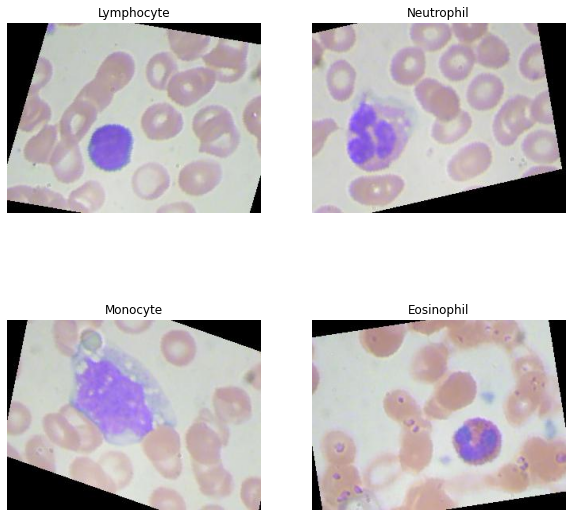

<Figure size 864x576 with 0 Axes>

In [3]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
def plotImage(h,w,image_path,title):
    image = cv2.imread(image_path)  # BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB
    axes[w,h].imshow(image)
    axes[w,h].axis('off')
    axes[w,h].set_title(title)
    
plt.figure(figsize=(12,8))
lymp_path = os.path.join(in_dir, 'TRAIN/LYMPHOCYTE') 
mono_path = os.path.join(in_dir, 'TRAIN/MONOCYTE')
neu_path = os.path.join(in_dir, 'TRAIN/NEUTROPHIL')
eos_path = os.path.join(in_dir, 'TRAIN/EOSINOPHIL')
plotImage(0,0,os.path.join(lymp_path, random.choice(os.listdir(lymp_path))),'Lymphocyte')
plotImage(0,1,os.path.join(mono_path, random.choice(os.listdir(mono_path))),'Monocyte')
plotImage(1,0,os.path.join(neu_path, random.choice(os.listdir(neu_path))),'Neutrophil')
plotImage(1,1,os.path.join(eos_path, random.choice(os.listdir(eos_path))),'Eosinophil')
plt.tight_layout()
plt.show()

Total Train samples: 9957

Total Test samples: 2487



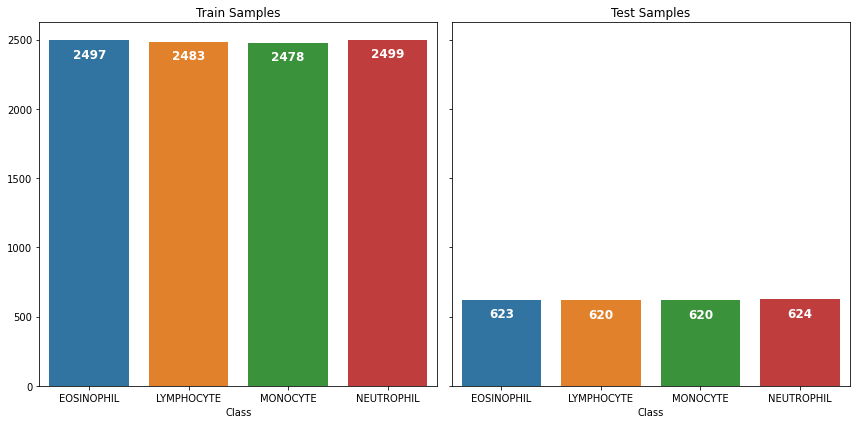

In [33]:
train_dir = os.path.join(in_dir, "TRAIN")
test_dir = os.path.join(in_dir, "TEST")
num_samples = 0
def plot_num_samples(path, s, ax):
    x = []
    y = []
    num_samples = 0
    for cls in os.listdir(path):
        num_imgs = len(os.listdir(os.path.join(path, cls)))
        num_samples += num_imgs
        x.append(cls)
        y.append(num_imgs)

    print('Total ' + s + ' samples: {:d}\n'.format(num_samples))
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_xlabel('Class')
    ax.set_title(s + ' Samples')
    for index, value in enumerate(y):
        ax.text(index, value-150, str(value), ha='center', va='bottom', color='white',weight='bold', fontsize=12)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
plot_num_samples(train_dir, "Train", ax1)
plot_num_samples(test_dir, "Test", ax2)
plt.tight_layout()
plt.show()

As you can see, the classes are almost completely equal in size, both in the train and in the test.


In [34]:
def equalize_hist_rgb(image):
    # Split the image into color channels
    b, g, r = cv2.split(image)

    # Apply histogram equalization to each channel
    b_eq = cv2.equalizeHist(b)
    g_eq = cv2.equalizeHist(g)
    r_eq = cv2.equalizeHist(r)

    # Merge the equalized channels back into an RGB image
    equalized_image = cv2.merge([b_eq, g_eq, r_eq])

    return equalized_image

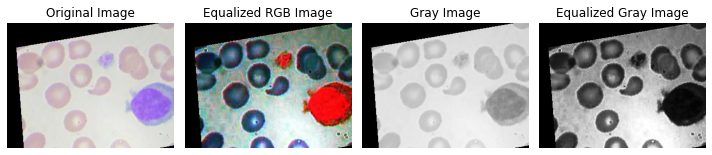

In [35]:
random_file = random.choice(os.listdir(lymp_path))
image = cv2.imread(os.path.join(lymp_path, random_file), cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(os.path.join(lymp_path, random_file))
image2 = image2[:, :, [2, 1, 0]]
image3 = cv2.imread(os.path.join(lymp_path, random_file))



# Perform histogram equalization
equalized_image = cv2.equalizeHist(image)
# Display the original and equalized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(image2)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(equalize_hist_rgb(image3))
plt.title('Equalized RGB Image')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Gray Image')
plt.axis('off')


plt.tight_layout()
plt.show()

Since we are mainly interested in being able to distinguish the abnormal blood cell and identify its shape, it seems that working on RGB format allows this in the best way (It can be seen that image processing by histogram equalization does not provide better results than normal RGB).

Later in the notebook we check the accuracy of the models with the images in grayscale.

In [36]:
def read_resize_img(path, t='RGB'):
    image = cv2.imread(path)  # BGR
    if t == 'RGB':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    elif t == 'GRAY':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_image = cv2.resize(image, (160, 120))
    return resized_image

In [37]:
def create_sub_df(directory_path,num_cls,t='RGB'):
    if t == 'RGB':
        images = np.ndarray((len(os.listdir(directory_path)),120*160*3), dtype=np.uint8)
    elif t == 'GRAY':
        images = np.ndarray((len(os.listdir(directory_path)),120*160), dtype=np.uint8)
    i=0
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        resized_image = read_resize_img(file_path,t)
        images[i,:] = resized_image.ravel()
        i+=1
    df = pd.DataFrame(images)
    df["target"] = num_cls
    return df

def create_df(directory_path,t='RGB'):
    clss = []
    for cls in os.listdir(directory_path):
        if str(cls) == "MONOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),1,t))
        elif str(cls) == "LYMPHOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),2,t))
        elif str(cls) == "NEUTROPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),3,t))
        elif str(cls) == "EOSINOPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),4,t))
    df = pd.concat(clss)
    return shuffle(df).reset_index(drop=True)

In [38]:
df_train = create_df(train_dir)
df_test = create_df(test_dir)

### PCA


PCA can effectively remove noise and irrelevant features from the images, enhancing the signal-to-noise ratio and improving the performance of subsequent machine learning algorithms.

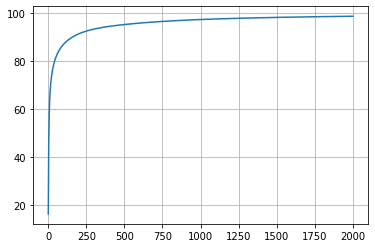

In [24]:
pca = PCA(n_components=2000)
pca.fit(df_train)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.savefig('pca.png')

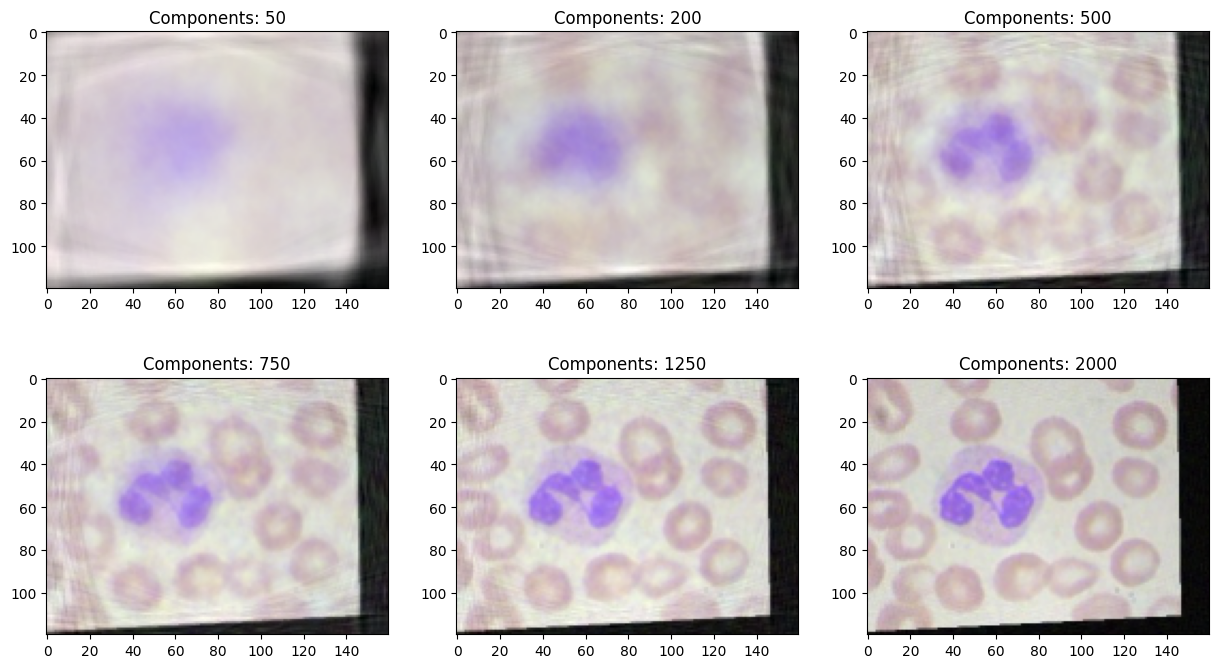

In [24]:
def plot_at_k(k):
    pca = PCA(n_components=k)
    x = df_first_2500.iloc[:, :-1]
    x = x.astype(float) / 255
    x = pca.fit_transform(x)
    dff = pd.DataFrame(pca.inverse_transform(x))
    image = np.array(dff.iloc[3, :]).reshape((120, 160, 3))
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Scale values between 0 and 1
    image = (image * 255).astype(np.uint8)  # Scale values between 0 and 255
    plt.imshow(image)

    
ks = [50, 200, 500, 750, 1250, 2000]
df_first_2500 = df_train.head(2500)
plt.figure(figsize=[15, 9])

for i in range(6):
    plt.subplot(2, 3, i+1)
    plot_at_k(ks[i])
    plt.title("Components: " + str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()

We set n_component = 2000 to get almost 100% of the variance of the data.

In [13]:
pca = PCA(n_components=2000)
df_train_reconstructed_pca = pca.inverse_transform(pca.fit_transform(df_train.iloc[:, :-1]))
df_test_reconstructed_pca = pca.inverse_transform(pca.transform(df_test.iloc[:, :-1]))

In [14]:
def scale_again_to_0_255(df):
    min_value = df.min().min()
    max_value = df.max().max()
    scaled_df = (df - min_value) * (255 / (max_value - min_value))

    # Convert the scaled DataFrame to uint8
    return scaled_df.astype(np.uint8)

In [15]:
df_train_reconstructed_pca = pd.DataFrame(df_train_reconstructed_pca)
df_test_reconstructed_pca = pd.DataFrame(df_test_reconstructed_pca)

In [16]:
df_train_reconstructed_pca = scale_again_to_0_255(df_train_reconstructed_pca)
df_test_reconstructed_pca = scale_again_to_0_255(df_test_reconstructed_pca)

In [17]:
df_train_reconstructed_pca['label'] = df_train.iloc[:, -1]
df_test_reconstructed_pca['label'] = df_test.iloc[:, -1]

In [18]:
df_train_reconstructed_pca.to_csv('train_pca.csv', index=False)
df_test_reconstructed_pca.to_csv('test_pca.csv', index=False)

In [75]:
df_train_reconstructed_pca

,0,1,2,3,4,5,6,7,8,9,...,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
0,48,46,46,49,48,47,54,53,52,53,...,46,45,46,46,55,57,56,53,54,52
1,193,190,191,203,201,201,205,203,202,203,...,53,50,48,50,52,50,50,52,50,51
2,53,54,53,52,53,51,52,54,52,54,...,49,55,57,55,54,56,54,52,54,52
3,55,55,55,51,51,52,50,50,51,50,...,53,55,56,56,55,55,55,48,48,49
4,55,54,58,56,55,58,49,47,51,46,...,49,47,47,46,45,45,44,56,55,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,54,54,55,48,48,49,48,47,49,47,...,52,52,50,53,50,49,50,49,47,49
9953,45,43,45,49,48,50,49,49,49,49,...,42,56,52,51,59,54,54,42,37,36
9954,52,50,50,47,45,45,41,39,39,48,...,52,56,57,56,55,55,55,52,52,52
9955,52,52,53,46,46,47,47,46,49,49,...,55,53,54,54,55,57,57,52,54,54


### Max Pooling

We applying max pooling to each image with a kernel size of (5, 5, 1) to reduce its dimension. This process transforms the original image size from (120,160,3) to (24,32,3). Max pooling is chosen for this task due to its ability to extract the most prominent features while reducing computational complexity. Max pooling operates by dividing the input image into non-overlapping regions, and for each region, it selects the maximum value. By doing so, it retains the most significant features from each region, effectively reducing the spatial dimensions of the image while preserving the essential information. Max pooling is particularly useful in computer vision tasks, as it helps in identifying the salient patterns and structures in images, thus enhancing the model's ability to learn relevant features during training and improving its overall performance.

In [76]:
def max_pooling(df):
    pooled_images = []  # List to store pooled images
    for i in range(len(df)):
        img = df.values[i].reshape(120, 160, 3)
        max_pool = block_reduce(img, block_size=(5, 5, 1), func=np.max)
        ravel_img = max_pool.ravel()
        pooled_images.append(ravel_img)

    # Create DataFrame from the pooled images list
    max_pool_df = pd.DataFrame(pooled_images)
    return max_pool_df

In [78]:
df_train_max_pool = max_pooling(pd.DataFrame(df_train_reconstructed_pca))
df_test_max_pool = max_pooling(pd.DataFrame(df_test_reconstructed_pca))

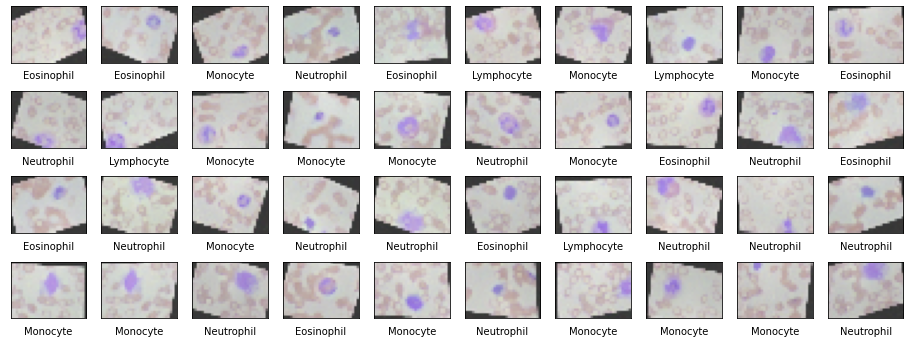

In [79]:
label = ["Monocyte", "Lymphocyte", "Neutrophil", "Eosinophil"]
input_data = df_train_max_pool
target = df_train.iloc[:, -1]
plt.figure(figsize=(16,6))

for i in range(40):
    plt.subplot(4,10, i+1)
    plt.xticks([])
    plt.yticks([])
    img = input_data.iloc[i, :] / 255
    plt.imshow(np.array(img).reshape(24,32,3))
    plt.xlabel(label[int(target[i])-1])

In [53]:
df_train_max_pool = df_train_max_pool.join(df_train.iloc[:, -1])
df_test_max_pool = df_test_max_pool.join(df_test.iloc[:, -1])

In [88]:
df_train_max_pool.to_csv('train_pca_maxpool.csv', index=False)
df_test_max_pool.to_csv('test_pca_maxpool.csv', index=False)

In [3]:
df_train_max_pool = pd.read_csv('train_pca_mpool.csv')
df_test_max_pool = pd.read_csv('test_pca_mpool.csv')

### Color reduction - KMeans

Before running the ML models the last preprocessing step involves Kmeans.

kmeans makes it possible to find a number of "centers" in the color space of the images and thus the colors of images can be converted into a limited number of different colors.

In [3]:
df_train_reconstructed_pca = df_train_reconstructed_pca.iloc[:, :-1]
df_test_reconstructed_pca = df_test_reconstructed_pca.iloc[:, :-1]

Here example for reduce colors on original images:

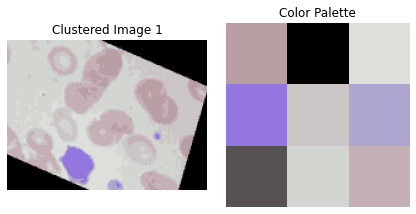

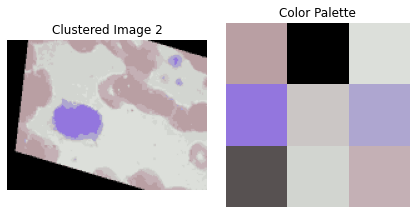

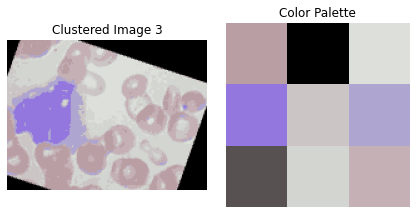

In [8]:
image_paths = [os.path.join(lymp_path, random.choice(os.listdir(lymp_path))),
               os.path.join(mono_path, random.choice(os.listdir(mono_path))),
               os.path.join(mono_path, random.choice(os.listdir(mono_path)))]
preprocessed_images = []
for path in image_paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    resized_image = cv2.resize(image, (160, 120))  # Resize if needed
    flattened_image = resized_image.reshape(-1, 3)  # Flatten the image to a feature vector
    preprocessed_images.append(flattened_image)

# Step 2: Combine the feature vectors
combined_data = np.concatenate(preprocessed_images, axis=0)

# Step 3: Apply k-means clustering
kmeans = KMeans(n_clusters=9, random_state=42,n_init=10)
kmeans.fit(combined_data)

# Step 4: Obtain cluster centroids and colors
centroids = kmeans.cluster_centers_
cluster_colors = centroids.astype(np.uint8)

# Step 5: Assign colors to images and plot color palette
for i, path in enumerate(image_paths):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    resized_image = cv2.resize(image, (160, 120))  # Resize if needed
    flattened_image = resized_image.reshape(-1, 3)  # Flatten the image to a feature vector
    
    # Assign nearest centroid color to each pixel
    labels = kmeans.predict(flattened_image)
    assigned_colors = cluster_colors[labels]
    clustered_image = assigned_colors.reshape(resized_image.shape)

    # Plot the clustered image and color palette
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    ax1.imshow(clustered_image)
    ax1.axis('off')
    ax1.set_title(f"Clustered Image {i+1}")

    color_palette = cluster_colors.reshape((3, 3, 3))
    ax2.imshow(color_palette)
    ax2.axis('off')
    ax2.set_title("Color Palette")

    plt.tight_layout()
    plt.show()

As you can see in the example, the concentration of colors using kmeans does not harm the color space of the image and still allows representing a unique color for the blood cell that we want to classify.

In [82]:
def reduce_colors(x_train,x_test):
    x_train = x_train.values.reshape(-1, 24*32, 3)
    x_test = x_test.values.reshape(-1, 24*32, 3)
    random_indices = random.sample(range(len(x_train)), k=20)
    random_samples_train = x_train[random_indices]

    combined_data = np.concatenate(random_samples_train, axis=0)
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
    kmeans.fit(combined_data)

    # Obtain cluster centroids
    centroids = kmeans.cluster_centers_
    centroids_uint8 = centroids.astype(np.uint8)  # Convert centroids to uint8

    train = []
    test = []
    # Assign colors to images
    for flattened_image in x_train:
        # Assign nearest centroid color to each pixel
        labels = kmeans.predict(flattened_image)
        train.append(centroids_uint8[labels])
    for flattened_image in x_test:
        labels = kmeans.predict(flattened_image)
        test.append(centroids_uint8[labels])
    return train, test

In [83]:
df_train_reduced_pca, df_test_reduced_pca = reduce_colors(df_train_max_pool,df_test_max_pool)

In [84]:
df_train_reduced_pca = np.array(df_train_reduced_pca).reshape(-1,24*32*3)
df_test_reduced_pca = np.array(df_test_reduced_pca).reshape(-1,24*32*3)

In [85]:
df_train_reduced_pca = pd.DataFrame(df_train_reduced_pca)
df_test_reduced_pca = pd.DataFrame(df_test_reduced_pca)

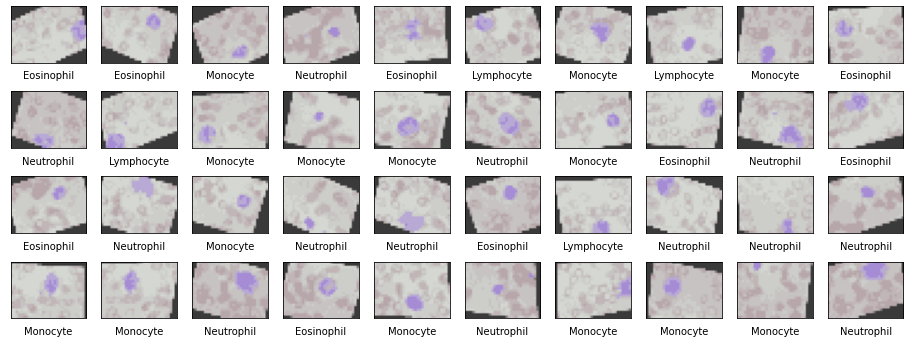

In [87]:
# img = df_train_reduced_pca.iloc[8, :] / 255
# plt.imshow(np.array(img).reshape(24, 32, 3))
label = ["Monocyte", "Lymphocyte", "Neutrophil", "Eosinophil"]
input_data = df_train_reduced_pca
target = df_train.iloc[:, -1]
plt.figure(figsize=(16,6))

for i in range(40):
    plt.subplot(4,10, i+1)
    plt.xticks([])
    plt.yticks([])
    img = input_data.iloc[i, :] / 255
    plt.imshow(np.array(img).reshape(24,32,3))
    plt.xlabel(label[int(target[i])-1])

In [91]:
df_train_reduced_pca.to_csv('train_reduce.csv', index=False)
df_test_reduced_pca.to_csv('test_reduce.csv', index=False)

In [4]:
df_train_reduced_pca = pd.read_csv('train_pca_mpool.csv')
df_test_reduced_pca = pd.read_csv('test_pca_mpool.csv')

# Models


Now we will start training the different models and presenting their prediction results. 
**We will be careful that the results will not be particularly good**, in our opinion due to the following reasons:
1. All the images are characterized by similar colors (this was the case even before kmeans), so it is difficult for the models to identify a unique characteristic for each class that can be used to classify.
2. The forms of the four classes are also similar to each other. Although Monocyte has more similarity to Lymphocyte and Neutrophil is more similar to Eosinophil but still in each class there are many different subforms.
3. The location of the objects is uneven. You can see in the examples we have given above that the purple cell is each time in a different position in the image.

In [5]:
def plot_confusion_matrix(model, X_train, y_train, X_test, y_test):
    labels = ["Monocyte", "Lymphocyte", "Neutrophil", "Eosinophil"]
    model.fit(X_train, y_train)
    
    # Model prediction
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Training Accuracy:", model.score(X_train, y_train))
    print("Testing Accuracy:", accuracy)
    print()
    print(classification_report(y_test, y_pred, labels=range(1,len(labels)+1), target_names=labels))
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot the confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax, linewidths=1)
    
    # Set labels, title, and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    
    # Set x-axis and y-axis tick labels
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    # Show the plot
    plt.show()

In [16]:
X_train, y_train = df_train_reduced_pca.iloc[:, :-1], df_train_reduced_pca.iloc[:, -1]
X_test, y_test = df_test_reduced_pca.iloc[:, :-1], df_test_reduced_pca.iloc[:, -1]

### Scaling

Scaling the data makes the models work better with the data.

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### KNN

First we will find the K that will give us the best accuracy in KNN.

In [18]:
k_range = list(range(1, 20, 1))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

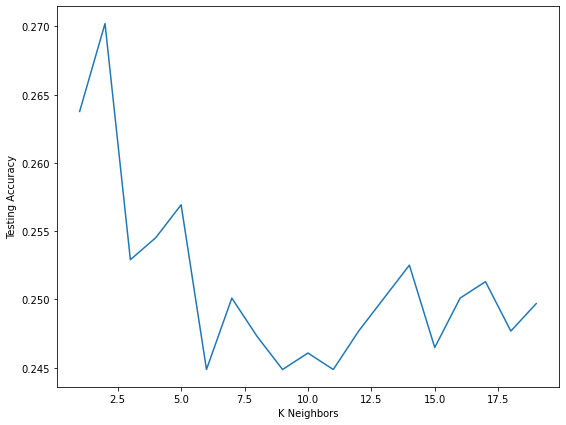

In [19]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scores)
plt.xlabel('K Neighbors')
plt.ylabel('Testing Accuracy')

Training Accuracy: 0.8052626293060159
Testing Accuracy: 0.27020506634499397

              precision    recall  f1-score   support

    Monocyte       0.25      0.36      0.30       620
  Lymphocyte       0.36      0.19      0.25       620
  Neutrophil       0.26      0.47      0.33       624
  Eosinophil       0.27      0.06      0.10       623

    accuracy                           0.27      2487
   macro avg       0.29      0.27      0.24      2487
weighted avg       0.29      0.27      0.24      2487



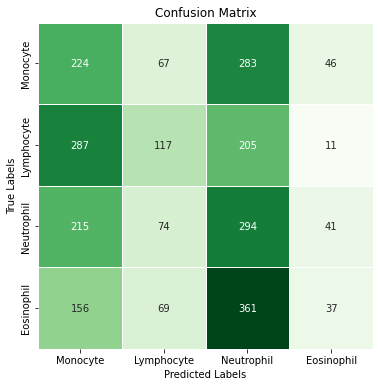

In [20]:
plot_confusion_matrix(KNeighborsClassifier(n_neighbors=2), X_train, y_train, X_test, y_test)

**The accuracy result of KNN is almost no better than a dummy model predicted by randomness.**

It can be seen that the model predicts most of the images as Neutrophil which leads to a higher recall for its class. This indicates a general falsification of the model that is unable to recognize different patterns that are in different locations. In our opinion, the model (and the other models below) do not achieve high accuracy because the blood cell position changes in each image and because the image is distorted.

KNN is generally not well-suited for classifying images, especially in cases where the images have complex variations and noise (as our case). Here are some reasons why KNN may struggle to succeed in image classification:

1. High-dimensional feature space: Images are represented by high-dimensional feature vectors, with each dimension corresponding to a pixel or a set of features. In high-dimensional spaces, the notion of distance becomes less meaningful, and the curse of dimensionality can lead to sparsity and increased computational complexity. This makes it challenging for KNN to accurately measure the similarity between images based on their feature vectors.

2. Sensitivity to irrelevant features: Images often contain a large number of irrelevant or noisy features that can hinder classification accuracy. KNN treats all features equally, which means it considers both relevant and irrelevant features during classification. This sensitivity to irrelevant features can lead to inaccurate results, especially when the noise or irrelevant features dominate the classification decision.

3. Lack of spatial information: KNN does not consider the spatial relationships and structural information present in images. It treats each pixel or feature independently without considering the arrangement or context of neighboring pixels. This can make it difficult for KNN to capture the meaningful spatial dependencies and patterns necessary for accurate image classification.

### Logistic Regression

The next model we used is logistic regression.
We ran the model twice in different versions, 'liblinear' and 'lbfgs' (Limited-memory Broyden-Fletcher-Goldfarb-Shanno).
The main differences between 'liblinear' and 'lbfgs' are in their design and use cases. 'liblinear' is specifically designed for large-scale linear classification and is suitable for datasets with a large number of samples and features. On the other hand, 'lbfgs' is a general optimization algorithm that can be applied to various optimization problems, including logistic regression, and is more suitable for smaller datasets.

Training Accuracy: 0.7283318268554786
Testing Accuracy: 0.3988741455568959

              precision    recall  f1-score   support

    Monocyte       0.55      0.60      0.57       620
  Lymphocyte       0.44      0.33      0.38       620
  Neutrophil       0.31      0.36      0.33       624
  Eosinophil       0.32      0.32      0.32       623

    accuracy                           0.40      2487
   macro avg       0.40      0.40      0.40      2487
weighted avg       0.40      0.40      0.40      2487



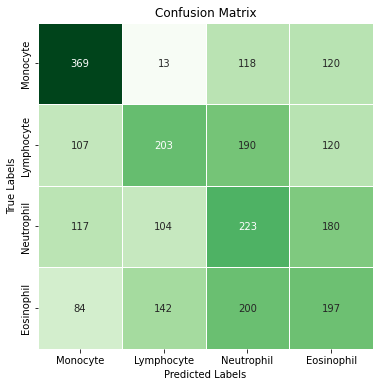

In [10]:
plot_confusion_matrix(LogisticRegression(solver='liblinear'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.7446017876870543
Testing Accuracy: 0.3956574185765983

              precision    recall  f1-score   support

    Monocyte       0.53      0.57      0.55       620
  Lymphocyte       0.44      0.32      0.37       620
  Neutrophil       0.31      0.38      0.34       624
  Eosinophil       0.32      0.31      0.31       623

    accuracy                           0.40      2487
   macro avg       0.40      0.40      0.39      2487
weighted avg       0.40      0.40      0.39      2487



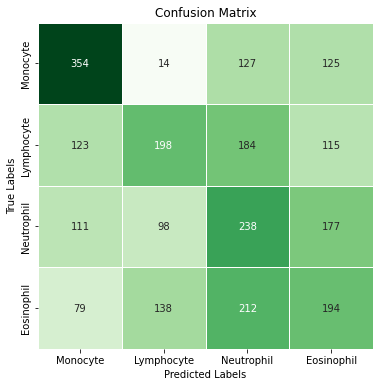

In [11]:
plot_confusion_matrix(LogisticRegression(solver='lbfgs',max_iter=4000), X_train, y_train, X_test, y_test)

We added iterations to allow convergence of the model.

The regression logistic model also gave not so good results, we will mention here some of the reasons -  
1. Comparison of features: In Logistic Regression we compare features, and in our dataset the important information is not found in exactly the same features in each image, this causes the model to fail to recognize the similarity between the images.
2. High-dimensional feature space: In image datasets, the feature space can become very high-dimensional due to the large number of pixels in each image. The curse of dimensionality can negatively impact the performance of logistic regression, making it challenging to find meaningful patterns or relationships in such high-dimensional spaces.
3. Model Complexity: logistic regression is relatively simple model. They may struggle to capture complex relationships in the data, especially if the true decision boundaries are non-linear or intricate.

*Logistic vs KNN*

Although we got not so good results, the results we got are better than what we got at KNN. It can be seen that there are more cases that are correctly classified (the squares diagonally from left-top to right-bottom) than in KNN.
We will mention some of the reasons for this - 
1. Local vs. Global Information: KNN is a lazy learner that relies on local information. It classifies a data point based on the labels of its k-nearest neighbors. In contrast, logistic regression optimizes a global objective function that takes into account information from the entire dataset. Depending on the dataset's characteristics, global information might be more suitable for achieving better separation between classes.
2. Noise Sensitivity: As we mentioned before, KNN can be sensitive to noisy data points, as it directly relies on the distances to neighbors. If the dataset contains noisy or outlier data points, it might negatively impact KNN's classification accuracy.

### SVM

We tested 3 types of kernels. 'linear', 'poly' and 'rbf'. The linear which is supposed to produce a linear separation - did not stop, so we stopped it. We estimate that the nature of the images (as we explained above) make it very difficult to create such a separation. 

As we will see later, 'rbf' will provide better results than 'poly'. This can be explained by the fact that a 'poly' type kernel is indeed able to capture non-linear relationships in the data and creating decision boundaries with curved shapes, but 'rbf' transforms the data into an infinite-dimensional space using Gaussian radial basis functions and allows it to be more flexible for highly non-linear data, as in our images.

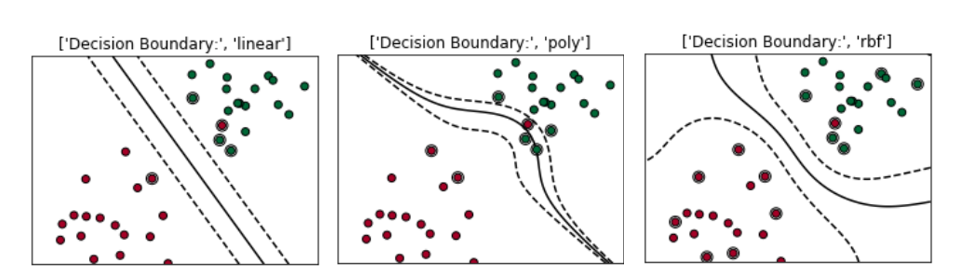

Training Accuracy: 0.8501556693783268
Testing Accuracy: 0.3220747889022919

              precision    recall  f1-score   support

    Monocyte       0.76      0.14      0.24       620
  Lymphocyte       0.71      0.23      0.35       620
  Neutrophil       0.27      0.66      0.38       624
  Eosinophil       0.26      0.26      0.26       623

    accuracy                           0.32      2487
   macro avg       0.50      0.32      0.31      2487
weighted avg       0.50      0.32      0.31      2487



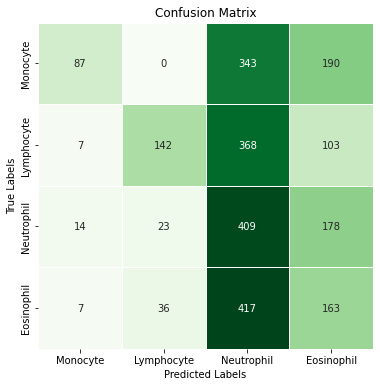

In [12]:
plot_confusion_matrix(SVC(C=0.5,kernel='poly'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.6440694988450336
Testing Accuracy: 0.4338560514676317

              precision    recall  f1-score   support

    Monocyte       0.70      0.58      0.63       620
  Lymphocyte       0.52      0.38      0.44       620
  Neutrophil       0.35      0.48      0.40       624
  Eosinophil       0.28      0.30      0.29       623

    accuracy                           0.43      2487
   macro avg       0.46      0.43      0.44      2487
weighted avg       0.46      0.43      0.44      2487



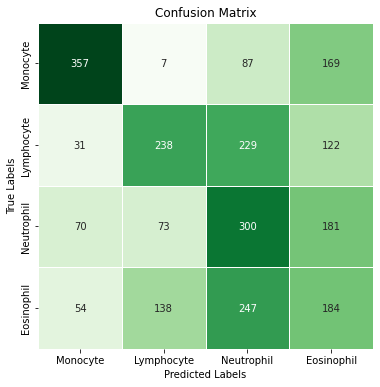

In [13]:
plot_confusion_matrix(SVC(C=0.25,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.7921060560409762
Testing Accuracy: 0.44189786891837557

              precision    recall  f1-score   support

    Monocyte       0.72      0.55      0.63       620
  Lymphocyte       0.58      0.42      0.48       620
  Neutrophil       0.33      0.51      0.40       624
  Eosinophil       0.29      0.29      0.29       623

    accuracy                           0.44      2487
   macro avg       0.48      0.44      0.45      2487
weighted avg       0.48      0.44      0.45      2487



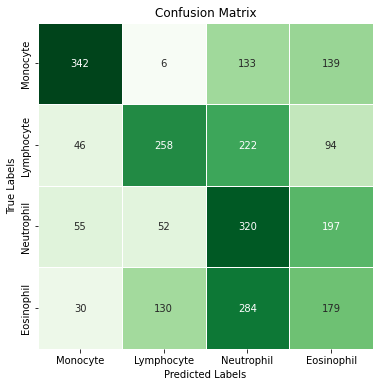

In [14]:
plot_confusion_matrix(SVC(C=0.5,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 0.9129255799939741
Testing Accuracy: 0.43104141535987134

              precision    recall  f1-score   support

    Monocyte       0.75      0.49      0.59       620
  Lymphocyte       0.60      0.43      0.50       620
  Neutrophil       0.33      0.54      0.41       624
  Eosinophil       0.27      0.27      0.27       623

    accuracy                           0.43      2487
   macro avg       0.49      0.43      0.44      2487
weighted avg       0.49      0.43      0.44      2487



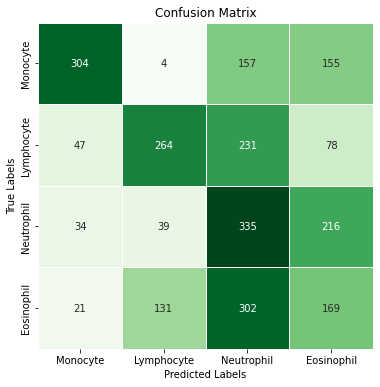

In [15]:
plot_confusion_matrix(SVC(C=1,kernel='rbf'), X_train, y_train, X_test, y_test)

Training Accuracy: 1.0
Testing Accuracy: 0.4189786891837555

              precision    recall  f1-score   support

    Monocyte       0.71      0.45      0.55       620
  Lymphocyte       0.59      0.39      0.47       620
  Neutrophil       0.32      0.54      0.40       624
  Eosinophil       0.29      0.30      0.30       623

    accuracy                           0.42      2487
   macro avg       0.48      0.42      0.43      2487
weighted avg       0.48      0.42      0.43      2487



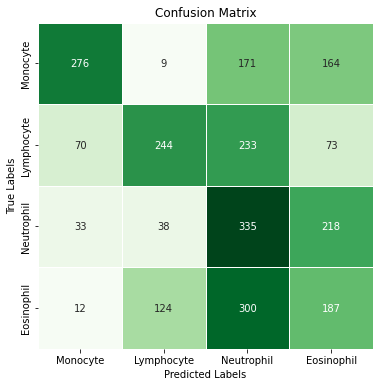

In [16]:
plot_confusion_matrix(SVC(C=10,kernel='rbf'), X_train, y_train, X_test, y_test)


We saw that SVM using 'rbf' achieves relatively better results than the models we have seen so far and with C=0.5 reaches 44.2% accuracy. It also does not overfit the train and achieves an accuracy of about 80%. The differences in accuracy are created by the definition of the C parameter.

The parameter C determines the penalty for misclassifying training examples. A smaller value of C allows for a wider margin, which may lead to some training examples being misclassified (soft margin). In contrast, a larger value of C imposes a stricter penalty for misclassification, leading to a narrower margin and potential overfitting (hard margin) - as in our case in C=10 (Train Accuracy is 100% vs Test accuracy 42%).

Here you can see an example:
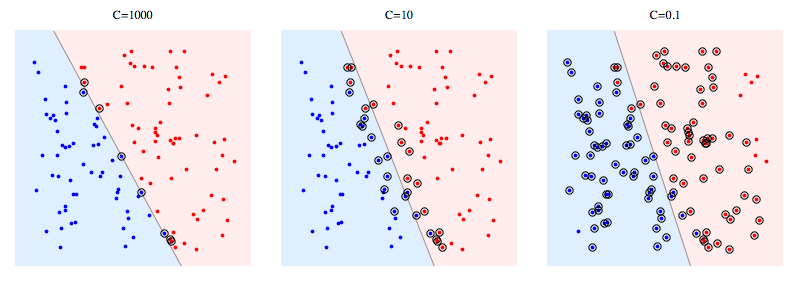

**It can be noticed that SVM manages to produce higher precision for Monocyte and Lymphocyte.**
In our opinion, this is because of the nature of these cells - they are characterized more by a lump than by a coiled strip like Neutrophil and Eosinophil.

### Decision Tree and Random Forest

Training Accuracy: 1.0
Testing Accuracy: 0.3333333333333333

              precision    recall  f1-score   support

    Monocyte       0.41      0.36      0.38       620
  Lymphocyte       0.38      0.32      0.35       620
  Neutrophil       0.29      0.35      0.32       624
  Eosinophil       0.29      0.30      0.29       623

    accuracy                           0.33      2487
   macro avg       0.34      0.33      0.33      2487
weighted avg       0.34      0.33      0.33      2487



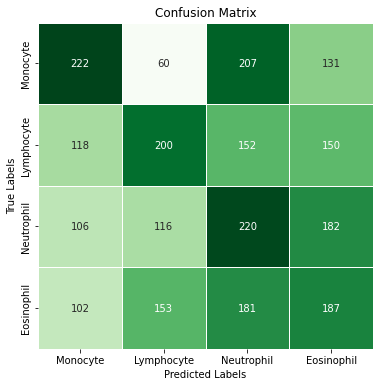

In [17]:
plot_confusion_matrix(DecisionTreeClassifier(random_state=0), X_train, y_train, X_test, y_test)

Decision Tree Decision Tree achieves extremely low accuracy - 33% and also suffers from overfitting. In our opinion, because Decision Tree has difficulty with non-linear separation and also does not have spatial vision because it treats each pixel separately - therefore it fails to handle images like ours. The overfitting is because of the wood that tends to deepen and adapt itself to the train.

<span style="color:red">Now we will limit the depth of the tree and this is how we will handle the overfitting problem:</span>.


Training Accuracy: 0.569147333534197
Testing Accuracy: 0.37072778447929233

              precision    recall  f1-score   support

    Monocyte       0.51      0.38      0.44       620
  Lymphocyte       0.47      0.22      0.30       620
  Neutrophil       0.31      0.42      0.36       624
  Eosinophil       0.32      0.46      0.38       623

    accuracy                           0.37      2487
   macro avg       0.40      0.37      0.37      2487
weighted avg       0.40      0.37      0.37      2487



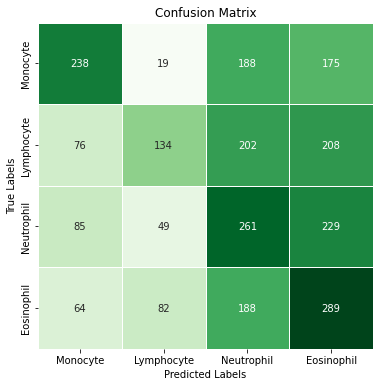

In [26]:
plot_confusion_matrix(DecisionTreeClassifier(random_state=0,max_depth=10), X_train, y_train, X_test, y_test)


<span style="color:red">We see that by setting *max_depth* = 10 - the gap between train accuracy and test accuracy decreased significantly, and also that test accuracy increased.</span>

<span style="color:red">Limiting the max_depth in a decision tree reduces overfitting by preventing the model from creating overly complex and intricate decision boundaries that capture noise and outliers in the training data. This constraint encourages the tree to focus on the most informative features and generalize better to unseen data, leading to improved performance on test sets.</span>


Training Accuracy: 1.0
Testing Accuracy: 0.44310414153598715

              precision    recall  f1-score   support

    Monocyte       0.73      0.56      0.64       620
  Lymphocyte       0.48      0.39      0.43       620
  Neutrophil       0.35      0.50      0.41       624
  Eosinophil       0.32      0.31      0.32       623

    accuracy                           0.44      2487
   macro avg       0.47      0.44      0.45      2487
weighted avg       0.47      0.44      0.45      2487



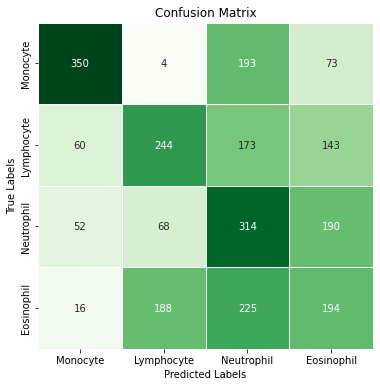

In [18]:
plot_confusion_matrix(RandomForestClassifier(random_state=0), X_train , y_train , X_test, y_test)

<span style="color:red">Here too there is overfitting when the depth of the trees is not limited, so we will try this time with a limit on *max_depth*:</span>

Training Accuracy: 0.8237420909912624
Testing Accuracy: 0.4628065942903096

              precision    recall  f1-score   support

    Monocyte       0.71      0.67      0.69       620
  Lymphocyte       0.48      0.38      0.42       620
  Neutrophil       0.39      0.39      0.39       624
  Eosinophil       0.33      0.42      0.37       623

    accuracy                           0.46      2487
   macro avg       0.48      0.46      0.47      2487
weighted avg       0.48      0.46      0.47      2487



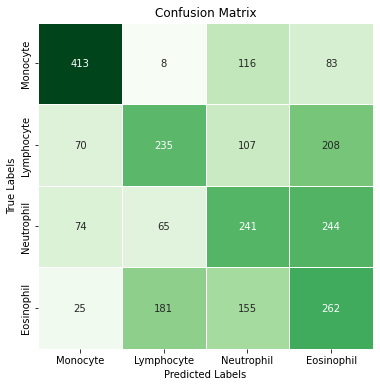

In [29]:
plot_confusion_matrix(RandomForestClassifier(random_state=0,max_depth=10), X_train , y_train , X_test, y_test)

<span style="color:red">As in the decision tree, also here with the *max_depth* limit the overfitting decreases and the test accuracy increases to 46%.</span>

Random Forest brings higher accuracy than Decision Tree. In our opinion, because of its ensemble nature that takes less into account noises and abnormal data and the fact that it trains different trees on several subsets of the data and thus manages to deal with diverse data.

Similar to SVM, the Random Forest also tends to higher precision in Monocyte and Lymphocyte, probably because of the lumpy shape.

### Voting

Voting is an ensemble model that can take advantage of different classification methods and thereby produce a better model for prediction.

Training Accuracy: 0.8404137792507783
Testing Accuracy: 0.46160032167269804

              precision    recall  f1-score   support

    Monocyte       0.63      0.69      0.66       620
  Lymphocyte       0.52      0.42      0.47       620
  Neutrophil       0.37      0.41      0.39       624
  Eosinophil       0.33      0.32      0.33       623

    accuracy                           0.46      2487
   macro avg       0.46      0.46      0.46      2487
weighted avg       0.46      0.46      0.46      2487



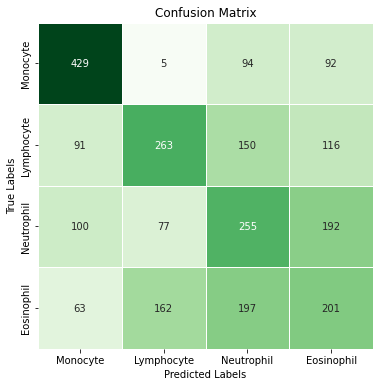

In [32]:
clf1 = LogisticRegression(solver='liblinear')
clf2 = RandomForestClassifier(random_state=0,max_depth=10)
clf3 = SVC(C=0.5,kernel='rbf')
vot = VotingClassifier(estimators=[ ('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='hard')
plot_confusion_matrix(vot, X_train, y_train, X_test, y_test)

<span style="color:red">It can be seen that voting does not give us better accuracy than random forest with *max_depth=10*.</span>

### Neural Network - CNN

The CNN network is good in that it learns the images spatially and not vectorially as we have done so far.

In [33]:
X_train_s, y_train_s = df_train.iloc[:, :-1], df_train.iloc[:, -1]
X_test_s, y_test_s = df_test.iloc[:, :-1], df_test.iloc[:, -1]
X_test_s, X_val, y_test_s, y_val = train_test_split(X_test_s, y_test_s, test_size = 0.5)

In [36]:
reshaped_X_train = X_train_s.to_numpy().reshape((9957, 120, 160, 3))
reshaped_X_test = X_test_s.to_numpy().reshape((1243, 120, 160, 3))
reshaped_X_val = X_val.to_numpy().reshape((1244, 120, 160, 3))

In [38]:
reshaped_X_train_s = reshaped_X_train_s / 255.0 
reshaped_X_val = reshaped_X_val / 255.0
reshaped_X_test_s = reshaped_X_test_s / 255.0

This convolutional neural network (CNN) architecture, consists of three convolutional layers, each followed by max pooling and dropout layers for regularization. The first convolutional layer has 16 filters of size (3,3) with a ReLU activation function, taking input images of size (120,160,3). The max pooling layer with a pool size of (2,2) reduces the spatial dimensions. The second convolutional layer has 32 filters with a ReLU activation, followed by max pooling and dropout with a rate of 0.25. The third convolutional layer has 64 filters with ReLU activation, followed by max pooling and dropout again. The fully connected (FC) layer flattens the output and connects to a dense layer of 128 units with ReLU activation and a dropout rate of 0.25 for further regularization. The output layer consists of 4 units with softmax activation for multi-class classification. The model is compiled with the Adam optimizer and uses sparse categorical cross-entropy as the loss function. The training is stopped early if the validation loss doesn't improve for 3 epochs, and the model is trained for a maximum of 50 epochs.

In [56]:
model = Sequential()

# First Conv Layer
model.add(Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (120,160,3)))
model.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv Layer
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Third Conv Layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# FC layer
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# Train
history1 = model.fit(
    reshaped_X_train_s, 
    y_train_s, 
    batch_size = 32, 
    epochs = 50, 
    validation_data=(reshaped_X_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 118, 158, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 59, 79, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 77, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 38, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 38, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 36, 64)       

The training of the model spans over 11 epochs, and it shows a notable improvement in both training and validation accuracy throughout the training process. The training accuracy starts at 26.32% and reaches 90.10% after 11 epochs, while the validation accuracy starts at 33.84% and increases to 77.73%. This indicates that the model is learning from the training data and generalizing well to the validation set.

Regarding overfitting, there are no clear signs of severe overfitting in this training process. The training accuracy does surpass the validation accuracy, which is expected, but the difference between the two remains relatively small. Additionally, the early stopping callback is triggered after 11 epochs when the validation loss stops improving. This suggests that the model is not continuously overfitting, as the validation loss does not increase substantially after the early stopping.

In [64]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(1,len(history.history['accuracy'])+1)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

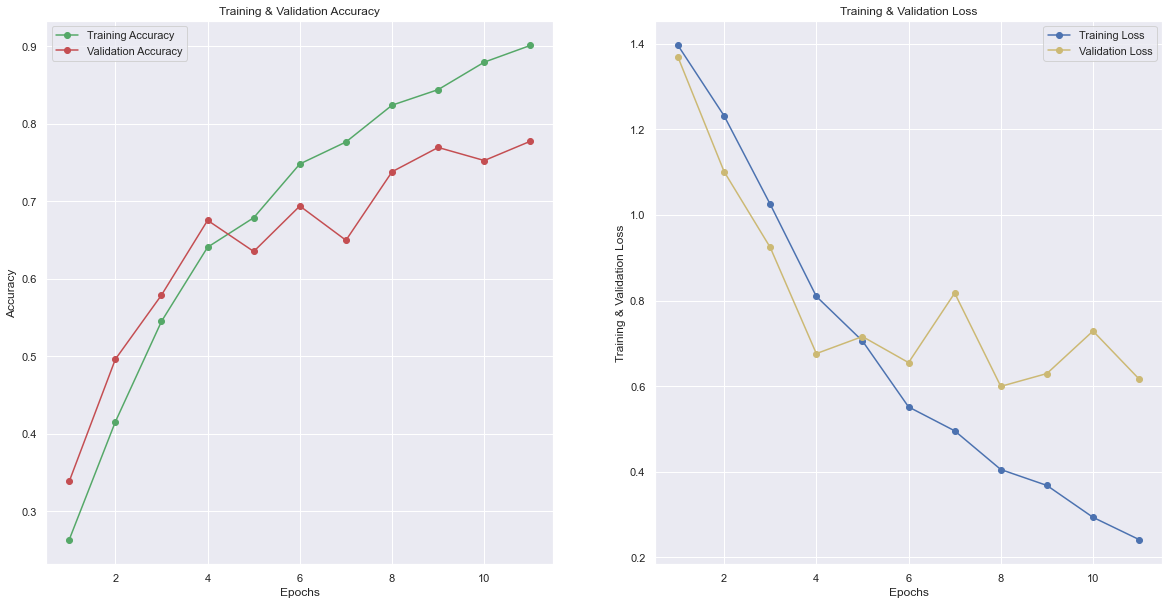

In [65]:
plot_accuracy_loss_chart(history1)


In the 11th epoch, after 3 epochs in which the validation loss did not decrease, the model stopped training.

In [61]:
results = model.evaluate(reshaped_X_test_s, y_test_s)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")

39/39 [==============================] - 4s 110ms/step - loss: 0.5940 - accuracy: 0.7836
Loss of the model  is - test  0.5940081477165222
Accuracy of the model is - test 78.35881114006042 %


CNN beats all the models we have seen so far and gives 78% on the test. In our opinion, this happens because of her way of learning that allows her to learn and identify objects.

### Unprocessed RGB images

We wanted to check what happens if we do not perform PCA and Max pooling. Does the information lost in these tools detract from the performance of the models? It turns out not. 

Here is the Random Forest model (which produced the best performance for the processed data). It can be seen that this results in <span style="color:red">*slightly*</span> lower accuracy:

Training Accuracy: 0.8428241438184192
Testing Accuracy: 0.4571773220747889

              precision    recall  f1-score   support

    Monocyte       0.71      0.69      0.70       620
  Lymphocyte       0.50      0.35      0.41       620
  Neutrophil       0.38      0.40      0.39       624
  Eosinophil       0.31      0.39      0.34       623

    accuracy                           0.46      2487
   macro avg       0.47      0.46      0.46      2487
weighted avg       0.47      0.46      0.46      2487



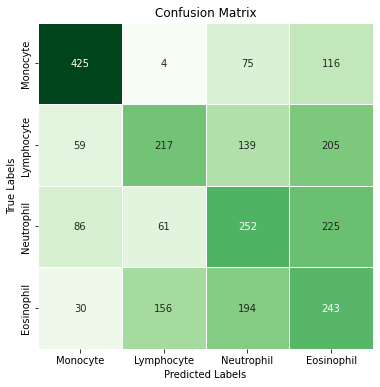

In [43]:
plot_confusion_matrix(RandomForestClassifier(random_state=0,max_depth=10), df_train.iloc[:, :-1] , df_train.iloc[:, -1] , df_test.iloc[:, :-1], df_test.iloc[:, -1])

It turns out that filtering the unimportant data <span style="color:red"> and reducing features</span> helped the models to reach higher accuracy <span style="color:red">(and also the calculation cost of the models decreased).</span>

## Grayscale images

We wanted to compare the results we have achieved so far against grayscale images. Perhaps, after all, grayscale manage to represent the difference between the blood cells at least as much as RGB shades (thus saving 2/3 of the features).

In [45]:
train_g = create_df(train_dir,t='GRAY')
test_g = create_df(test_dir,t='GRAY')

In [46]:
train_g

,0,1,2,3,4,5,6,7,8,9,...,19191,19192,19193,19194,19195,19196,19197,19198,19199,target
0,0,0,0,0,0,0,0,0,1,1,...,1,2,2,2,3,1,1,1,1,2
1,0,0,0,0,0,0,0,0,0,0,...,4,2,5,2,2,1,1,0,1,3
2,0,0,0,0,0,0,0,0,3,3,...,0,0,0,0,0,0,0,0,0,4
3,0,0,1,1,4,157,203,207,207,207,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,2,2,215,212,216,...,213,213,213,213,213,216,210,220,214,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,0,0,0,0,0,0,0,0,0,0,...,173,175,177,167,161,163,162,167,175,4
9953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
9954,0,0,0,0,0,0,0,0,0,0,...,207,207,207,206,205,206,206,206,206,1
9955,0,0,0,0,0,0,0,0,0,0,...,194,207,210,209,211,210,210,209,208,1


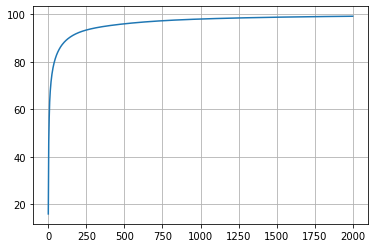

In [29]:
pcag = PCA(n_components=2000)
pcag.fit(train_g)
plt.grid()
plt.plot(np.cumsum(pcag.explained_variance_ratio_*100))
plt.savefig('pcag.png')

In [55]:
pcag = PCA(n_components=1800)
train_g_reconstructed_pca = pd.DataFrame(pcag.inverse_transform(pcag.fit_transform(train_g.iloc[:, :-1])))
test_g_reconstructed_pca =  pd.DataFrame(pcag.inverse_transform(pcag.transform(test_g.iloc[:, :-1])))

In [56]:
def max_pooling_g(df):
    pooled_images = []  # List to store pooled images
    for i in range(len(df)):
        img = df.values[i].reshape(120, 160)
        max_pool = block_reduce(img, block_size=(4, 4), func=np.max)
        ravel_img = max_pool.ravel()
        pooled_images.append(ravel_img)

    # Create DataFrame from the pooled images list
    max_pool_df = pd.DataFrame(pooled_images)
    return max_pool_df
train_g_reconstructed_pca = max_pooling_g(train_g_reconstructed_pca)
test_g_reconstructed_pca = max_pooling_g(test_g_reconstructed_pca)

In [57]:
train_g_reconstructed_pca

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,11.402322,9.884524,13.756284,11.672164,11.054546,8.715051,14.359948,15.371298,6.852262,12.452216,...,214.402921,213.387822,211.680874,211.794770,210.717940,170.546777,141.874958,98.481351,65.220246,22.350486
1,5.036539,6.903683,7.601580,11.691608,7.045180,10.262768,8.696209,4.496307,4.112833,7.409319,...,178.516623,199.573479,204.825394,202.175790,180.310724,189.908245,205.515705,177.325677,179.893594,25.670451
2,5.748154,3.549914,195.322530,197.529599,204.863815,194.024720,200.995180,202.182246,176.875519,149.896067,...,208.018392,211.506970,215.494722,213.987221,210.163648,210.978042,213.547270,21.843971,5.032170,4.969331
3,11.571977,211.623704,217.373858,213.781188,218.120891,220.912694,219.552476,194.631744,198.897945,213.196504,...,162.532443,202.138745,207.999056,208.149478,207.253847,202.172367,208.477066,8.457110,4.669823,5.552134
4,8.321351,191.627120,225.593524,209.995415,186.128640,183.839838,181.001311,190.201998,221.696053,228.708100,...,213.293927,182.868331,195.204051,202.963376,190.602376,214.285383,223.587801,221.613508,220.000943,225.093399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,6.916986,9.383436,9.531450,4.793076,5.053718,3.124985,3.671476,3.583591,5.833643,9.371130,...,219.026444,221.215286,203.588179,200.847261,198.200848,190.226418,185.622214,202.043738,175.639686,167.923287
9953,7.718841,7.103865,11.978079,5.475415,5.353733,5.820815,3.478468,6.485682,8.131264,3.018941,...,5.094352,3.442826,4.671040,8.103851,9.234698,7.106816,6.108528,5.927630,11.943733,7.889339
9954,9.424763,8.977868,5.597222,7.006698,5.178890,196.529920,209.678202,207.792416,191.291371,184.139643,...,215.937185,191.142432,217.192446,219.906976,214.069793,217.705874,218.017813,215.848915,214.038564,219.911213
9955,10.198212,6.190178,5.368506,4.434778,29.201485,200.228415,188.354786,185.831850,185.982551,186.438177,...,219.250867,222.157197,224.919273,214.881762,193.946193,198.674264,192.833885,196.708090,217.145793,220.119721


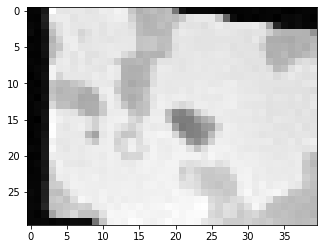

In [58]:
img = train_g_reconstructed_pca.iloc[6, :]
plt.imshow(np.array(img).reshape(30, 40),cmap='gray')

In [59]:
scaler = StandardScaler()
X_train_g = scaler.fit_transform(train_g_reconstructed_pca)
X_test_g = scaler.transform(test_g_reconstructed_pca)

### Grayscale - Models

In [60]:
k_range = list(range(1, 20, 1))
scoresg = []
for k in k_range:
    knng = KNeighborsClassifier(n_neighbors=k)
    knng.fit(X_train_g, train_g.iloc[:, -1])
    y_pred = knng.predict(X_test_g)
    scoresg.append(accuracy_score(test_g.iloc[:, -1], y_pred))

Text(0, 0.5, 'Testing Accuracy')

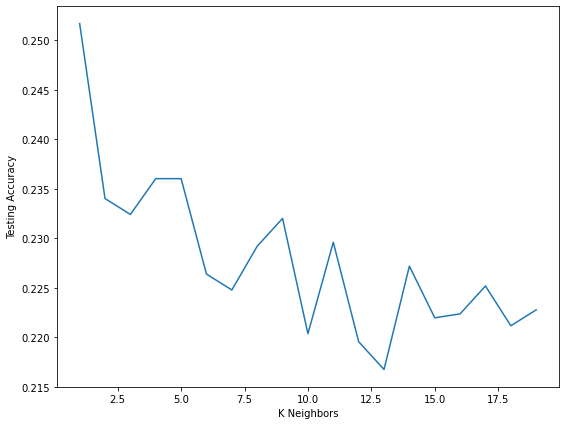

In [61]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scoresg)
plt.xlabel('K Neighbors')
plt.ylabel('Testing Accuracy')

Training Accuracy: 1.0
Testing Accuracy: 0.2517088862082831

              precision    recall  f1-score   support

    Monocyte       0.22      0.19      0.20       620
  Lymphocyte       0.43      0.17      0.24       620
  Neutrophil       0.23      0.40      0.29       624
  Eosinophil       0.26      0.25      0.25       623

    accuracy                           0.25      2487
   macro avg       0.28      0.25      0.25      2487
weighted avg       0.28      0.25      0.25      2487



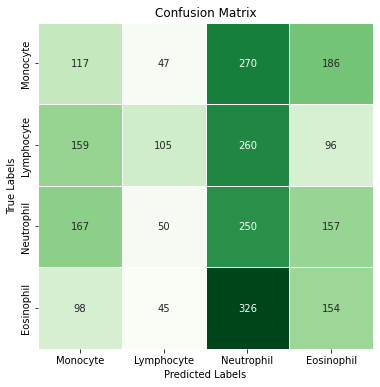

In [62]:
plot_confusion_matrix(KNeighborsClassifier(n_neighbors=1), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Here the model not better than dummy model (25%)


Training Accuracy: 0.5055739680626695
Testing Accuracy: 0.26537997587454765

              precision    recall  f1-score   support

    Monocyte       0.28      0.27      0.28       620
  Lymphocyte       0.30      0.31      0.31       620
  Neutrophil       0.24      0.26      0.25       624
  Eosinophil       0.23      0.22      0.23       623

    accuracy                           0.27      2487
   macro avg       0.27      0.27      0.27      2487
weighted avg       0.27      0.27      0.27      2487



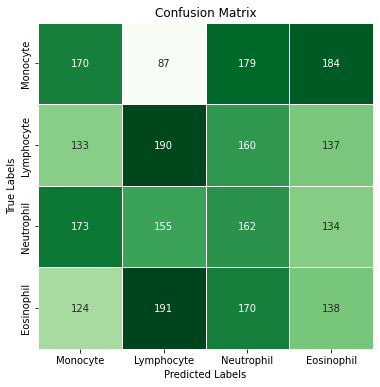

In [43]:
plot_confusion_matrix(LogisticRegression(solver='liblinear'), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 0.504268353921864
Testing Accuracy: 0.26457579412947324

              precision    recall  f1-score   support

    Monocyte       0.28      0.27      0.28       620
  Lymphocyte       0.30      0.31      0.30       620
  Neutrophil       0.24      0.26      0.25       624
  Eosinophil       0.24      0.22      0.23       623

    accuracy                           0.26      2487
   macro avg       0.27      0.26      0.26      2487
weighted avg       0.26      0.26      0.26      2487



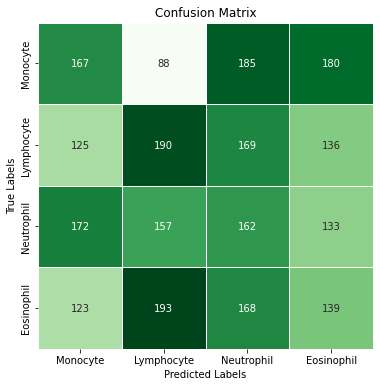

In [44]:
plot_confusion_matrix(LogisticRegression(solver='lbfgs',max_iter=4000), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 0.49653510093401626
Testing Accuracy: 0.24205870526739043

              precision    recall  f1-score   support

    Monocyte       0.20      0.09      0.12       620
  Lymphocyte       0.45      0.21      0.29       620
  Neutrophil       0.26      0.23      0.25       624
  Eosinophil       0.20      0.43      0.27       623

    accuracy                           0.24      2487
   macro avg       0.28      0.24      0.23      2487
weighted avg       0.28      0.24      0.23      2487



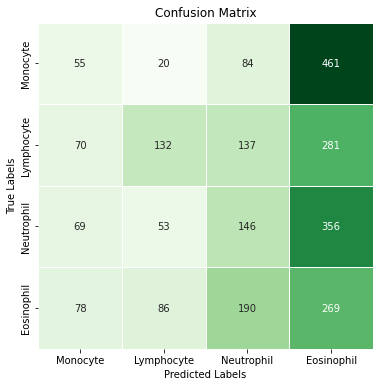

In [63]:
plot_confusion_matrix(DecisionTreeClassifier(random_state=0,max_depth=10), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 0.7996384453148538
Testing Accuracy: 0.31523924406915965

              precision    recall  f1-score   support

    Monocyte       0.36      0.25      0.30       620
  Lymphocyte       0.44      0.39      0.42       620
  Neutrophil       0.41      0.33      0.37       624
  Eosinophil       0.18      0.29      0.22       623

    accuracy                           0.32      2487
   macro avg       0.35      0.32      0.32      2487
weighted avg       0.35      0.32      0.32      2487



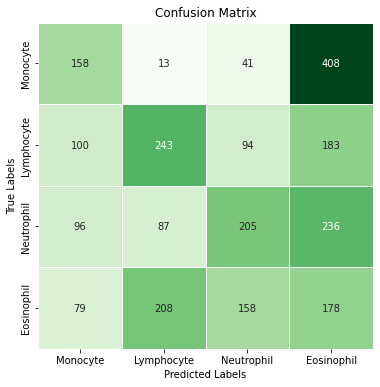

In [64]:
plot_confusion_matrix(RandomForestClassifier(random_state=0,max_depth=10), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

Training Accuracy: 0.692979813196746
Testing Accuracy: 0.28990751909931645

              precision    recall  f1-score   support

    Monocyte       0.27      0.15      0.20       620
  Lymphocyte       0.55      0.35      0.43       620
  Neutrophil       0.27      0.40      0.32       624
  Eosinophil       0.19      0.26      0.22       623

    accuracy                           0.29      2487
   macro avg       0.32      0.29      0.29      2487
weighted avg       0.32      0.29      0.29      2487



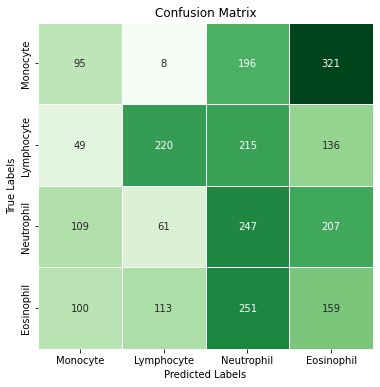

In [47]:
plot_confusion_matrix(SVC(C=0.5,kernel='rbf'), X_train_g, train_g.iloc[:, -1], X_test_g, test_g.iloc[:, -1])

As we have seen, **the models on grayscale images produce significantly lower accuracies than models on RGB images**. In our opinion **this happens because in RGB there is a uniqueness to the blood cell that we are interested in classifying, this is in contrast to grayscale where a similar shade is spread all over the image**, thus making it difficult to predict.

# Summary

**Challenges in our data:**
1. Images data
2. Distorted images
3. Non-fixed location of the object to be classified
4. Multi class

**Problems we encountered during the project:**
1. Maintaining a color space that will allow identification of the object for classification.
2. A huge amount of features - not good for fitting models.

**Solutions we were able to obtain for the problems:**
1. Using the RGB color space so that the blood cells for classification were kept in a unique color.
2. Filtering unimportant information using PCA and dimensionality reduction using Max Pooling.

We also tried to train models on the original unprocessed image data and on the grayscale image data, but they did not yield higher accuracies.
In his estimation, the grayscale images lack important information and the unprocessed images contain unnecessary noise, therefore the accuracy is lower.

Apparently, if advanced image processing processes are performed on the images so that only the locations where the blood cell is found are captured, the accuracy will improve significantly.

**Despite all the difficulties, we managed to obtain an accuracy of 46% (Random Forest model), which is more than a dummy model that is accurate by 25% (4 classes). And of course the CNN network that provides 78%..**


